In [79]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin, classification_report

from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc

In [2]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras import regularizers

Using TensorFlow backend.


In [3]:
# Read the data
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [271]:
#Start by implementing a model


# -*- Mode: python -*-
# A simple reference recommender
#
#
# This is a medical scenario with historical data. 
#
# General functions
#
# - set_reward
# 
# There is a set of functions for dealing with historical data:
#
# - fit_data
# - fit_treatment_outcome
# - estimate_utiltiy
#
# There is a set of functions for online decision making
#
# - predict_proba
# - recommend
# - observe

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np


class NNDoctor:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 32, 16],
                 batch_size=32,
                 epochs=10,
                 optimizer="adam",
                 loss="binary_crossentropy",
                 alpha = 0.001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def predict_classes(self, X):
        return self.model.predict_classes(X)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(self.n_outcomes, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()

In [321]:
# fit on actions instead of outcome

class HistoricalRecommender:

    model = None

    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    def set_reward(self, reward):
        self.reward = reward

    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor(n_actions=self.n_actions, n_outcomes=self.n_outcomes)
        self.model.fit(data, actions)
        #print(self.model.best_params_)
        return self.model

    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            policy_actions = np.array([policy.recommend(x) for x in data])
            predicted_outcomes = self.model.predict(np.concatenate((data, policy_actions.reshape(-1,1)), axis=1))
            return self.reward(policy_actions, predicted_outcomes.reshape(1,-1)).mean()

    def predict_proba(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        pred = self.model.predict(data)
        return pred

    def predict_classes(self, data, treatment):
        #predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        predictions_classes = self.model.predict_classes(data)
        return predictions_classes

    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            #estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_outcome = self.model.predict(user_data.reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))

    def recommend(self, user_data):
        return np.asscalar(self.model.predict_classes(user_data.reshape(1,-1)))
        #return np.argmax(self.get_action_probabilities(user_data))

    def observe(self, user, action, outcome):
        return None

    def final_analysis(self):
        return None

In [322]:
nn = HistoricalRecommender(n_actions = len(np.unique(actions)), n_outcomes = outcome.shape[1])
print(len(np.unique(actions)))

f_train, f_test, a_train, a_test, o_train, o_test = train_test_split(features, actions, outcome, test_size=.3)

2


In [323]:
# fit the data on the features and the action (outcome is disregarded here)

nn.fit_treatment_outcome(f_train, a_train, o_train)

Fitting treatment outcomes


In [324]:
print(np.concatenate((f_train, a_train), axis=1).shape)
print(f_train.shape)

(7000, 131)
(7000, 130)


In [325]:
print(f_test.shape)
print(a_test.shape)

(3000, 130)
(3000, 1)


In [326]:
# predicts the probability of action 0

nn.predict_proba(f_test, a_test)

array([[0.45924413],
       [0.4863152 ],
       [0.00703335],
       ...,
       [0.6107617 ],
       [0.4608381 ],
       [0.29495192]], dtype=float32)

In [327]:
pred = nn.predict_classes(f_test, a_test)

unique, counts = np.unique(pred, return_counts=True)
print('prediction:', dict(zip(unique, counts)))

unique, counts = np.unique(a_test, return_counts=True)
print('actual:', dict(zip(unique, counts)))

print(classification_report(a_test, pred))

prediction: {0: 2282, 1: 718}
actual: {0: 2322, 1: 678}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2322
           1       0.50      0.53      0.51       678

    accuracy                           0.77      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.78      0.77      0.77      3000



In [328]:
action_prob = nn.get_action_probabilities(features[15,:])
#print(action_prob.shape)

In [329]:
nn.get_action_probabilities(features[15,:])

array([0.52497919, 0.47502081])

In [331]:
nn.recommend(features[15,:])

0

In [332]:
recommend = []
for x in range(f_test.shape[0]):
    recommend.append(nn.recommend(features[x,:]))

In [334]:
unique, counts = np.unique(recommend, return_counts=True)
print('actual:', dict(zip(unique, counts)))

actual: {0: 2281, 1: 719}


In [280]:
# Exercise 1.1:
# Implemented estimate_utility above
#rec = RandomRecommender(actions.shape[1], actions.shape[1])
nn.estimate_utility(features, actions, outcome)

0.11912

mean utility: 0.1190
Utility std: 0.0033


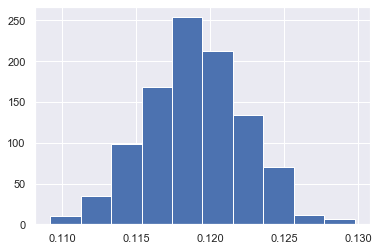

In [7]:
# Exercise 1.2:
# Use bootstrap on the historical dataset to estimate variance of the utility
n = features.shape[0]
num_samples = 1000
utils = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = features[randlist]
    sample_actions = actions[randlist]
    sample_outcome = outcome[randlist]
    utils.append(nn.estimate_utility(sample_features, sample_actions, sample_outcome))
plt.hist(utils)
print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

mean utility: 0.1671
Utility std: 0.0027


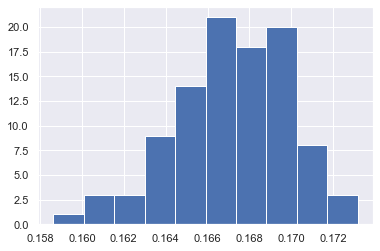

In [8]:
#Exercise 2.1:

n = f_test.shape[0]
num_samples = 100
utils = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = f_test[randlist]
    sample_actions = a_test[randlist]
    sample_outcome = o_test[randlist]
    utils.append(nn.estimate_historic_utility(sample_features, sample_actions, sample_outcome))
plt.hist(utils)
print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

In [9]:
nn.estimate_utility(f_test, a_test, o_test)

0.11323333333333335

In [10]:
#Excercise 2.2:

nn.estimate_utility(f_test, a_test, o_test, nn)

0.18114581598639487